## IMPORTING LIBRARIES AND CONNECTING MYSQL

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Somnath.Kajal@2002",
                             database = "ecommerce",
                             consume_results=True
                            )
cur = db.cursor()
cnx = mysql.connector.connect()

## BASIC QUERIES

### List all cities where customers are located

In [103]:
query1 = """ select distinct customer_city from customers """
cur.execute(query1)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Customer_City"])
df.head()

,Customer_City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### Count the number of orders placed in 2017

In [44]:
query2 = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query2)
data = cur.fetchall()
"total orders placed in 2017 are : ", data[0][0]

('total orders placed in 2017 are : ', 90202)

### Find the total sales per category 

In [57]:
query3 = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """
cur.execute(query3)
data = cur.fetchall()
pd.DataFrame(data, columns = ["Category","Sales"])

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### Calculate the percentage of orders that were paid in installments

In [72]:
query4 = """ select (sum(case when payment_installments>=1 then 1
else 0 end))/count(*)*100 from payments """
cur.execute(query4)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

### Count the number of customers from each state

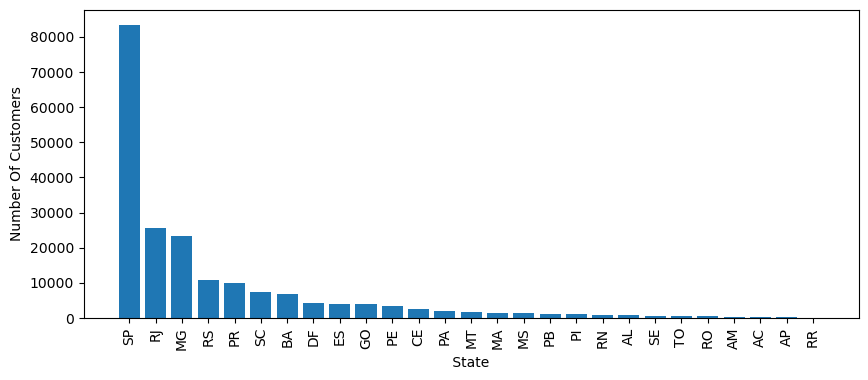

In [126]:
query5 = """ select customer_state, count(customer_id) from customers group by customer_state """
cur.execute(query5)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State","No. Of Customers"])
df = df.sort_values(by = "No. Of Customers", ascending = False)

plt.figure(figsize=(10,4))
plt.bar(df["State"], df["No. Of Customers"])
plt.xticks(rotation=90)
plt.xlabel(" State ")
plt.ylabel("Number Of Customers")
plt.show()

## INTERMEDIATE QUERIES

### Calculate the number of orders per month in 2018

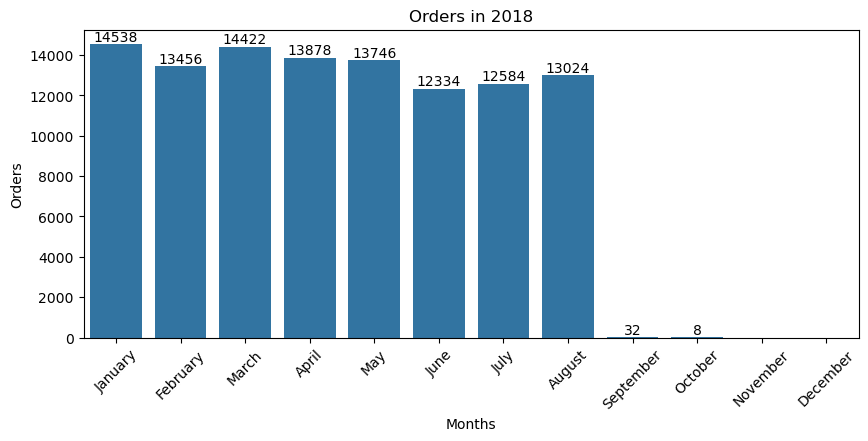

In [144]:
query = """ select monthname(order_purchase_timestamp) as Month,count(order_id) as Orders
from orders where year(order_purchase_timestamp) = 2018
group by Month"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Month","Orders"])
months_ordered = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

plt.figure(figsize=(10,4))
ax = sns.barplot(x=df["Month"],y=df["Orders"],data=df,order=months_ordered)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Orders in 2018")
plt.xlabel("Months")
plt.ylabel("Orders")
plt.show()

### Find the average number of products per order, grouped by customer city

In [169]:
query = """ with count_per_order as (select orders.customer_id,orders.order_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.customer_id,orders.order_id )
select customers.customer_city, round(avg(count_per_order.oc),0) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city order by average_orders desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1
0,padre carvalho,14
1,celso ramos,13
2,datas,12
3,candido godoi,12
4,matias olimpio,10
...,...,...
4105,sebastiao leal,2
4106,tibau do sul,2
4107,morro agudo de goias,2
4108,sao mamede,2


### Calculate the percentage of total revenue contributed by each product category.

In [17]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value))/(select sum(payment_value) from payments)*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc"""
cur.execute(query)
data = cur.fetchall()
pd.DataFrame(data, columns = ["Category","Sales_percentage"])

,Category,Sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


### Identify the correlation between product price and the number of times a product has been purchased.

In [28]:
query = """ select products.product_category as cat,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by cat """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Product_category","Order_Count","price(avg)"])
arr1 = df["Order_Count"]
arr2 = df["price(avg)"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

### Calculate the total revenue generated by each seller and rank them by revenue.

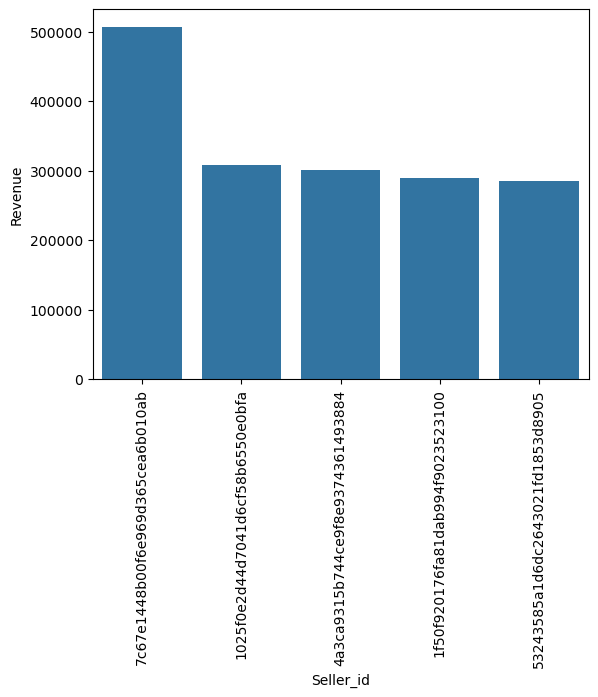

In [39]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,
round(sum(payments.payment_value),2) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["Seller_id","Revenue","Rank"])

sns.barplot(x="Seller_id",y="Revenue",data=df.head())
plt.xticks(rotation=90)
plt.show()

## ADVANCED QUERIES

### Calculate the moving average of order values for each customer over their order history.

In [46]:
query = """ select customer_id,order_purchase_timestamp,
payment, avg(payment) over(partition by customer_id order by 
order_purchase_timestamp rows between 2 preceding and current row)
as mov_avg from (select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment from orders join payments
on orders.order_id = payments.order_id) as cust """
cur.execute(query)
data = cur.fetchall()
pd.DataFrame(data,columns=["Order_id","Purchage_timestamp","Price","Moving_avg"])

,Order_id,Purchage_timestamp,Price,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


### Calculate the cumulative sales per month for each year.

In [72]:
query = """ select years, months, payment, sum(payment) 
over(order by years,months) as cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months, 
round(sum(payments.payment_value)) as payment
from orders join payments on orders.order_id = payments.order_id
group by years, months order by years,months) as o """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Year","Month","Sales","Cumulative_Sales"])
df.head()

,Year,Month,Sales,Cumulative_Sales
0,2016,9,504.0,504.0
1,2016,10,118181.0,118685.0
2,2016,12,39.0,118724.0
3,2017,1,276976.0,395700.0
4,2017,2,583816.0,979516.0


### Calculate year over year growth rate of total sales

In [88]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value)) as payment
from orders join payments on
orders.order_id = payments.order_id
group by years order by years)
select years,payment,((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100
from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Year","Sales","year_by_year_%growth"])
df.head()

,Year,Sales,year_by_year_%growth
0,2016,118725.0,NaN
1,2017,14499493.0,12112.670457
2,2018,17399526.0,20.000927
